In [53]:
#######################
# plot_density_ne_europa.py
#---------------------
# This routine reads the density
#  file and plot the map in 
# the XY and XZ plane
#
# C. Baskevitch
# UVSQ-LATMOS
# claire.baskevitch@latmos.ipsl.fr
# November 2020
#######################

from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import math
import sys, os


def plot_density_ne(src_dir,typefile,rundate,diagtime,zoom=True):
	ncfile = src_dir + typefile + rundate + "_t" + diagtime + '.nc' #'_extract_4Re_grid.nc'#

	ncid = Dataset(ncfile)
	var_nc = ncid.variables
	# print(var_nc)

	# planetname = var_nc['planetname'][:]
	centr      = var_nc['s_centr'][:] # 3dim: planet center position
	radius     = var_nc['r_planet'][:] # 1dim: planet radius
	gs         = var_nc['gstep'][:] # space_dim(depend on the results?): grid length?
	nptot      = var_nc['nptot'][:] # number of particles in the simulation
	Dn         = var_nc['Density'][:] # /cc
	# nrm        = var_nc['phys_density'][:]
	nrm_len    = var_nc['phys_length'][:]
	# X_axis = var_nc["X_axis"][:]
	# Y_axis = var_nc["Y_axis"][:]
	# Z_axis = var_nc["Z_axis"][:]

	# radius=1
	nc = [len(Dn[0][0]), len(Dn[0]), len(Dn)] #like [len(x),len(y),len(z)]
	print(var_nc['X_axis'][:])

	Dn = np.where(Dn <= 0, float('NaN'), Dn)
	# maximum and minimum 
	if radius > 1.0:
		min_val = 0.
		max_val = 5.
	else:
		min_val = 1.5 # log(cm-3) for run without planete
		max_val = 1.6  # log(sm-3) for run without planete

	# -- Creation of axis values centered on the planet ( normalized to planet radius)
	X_XY, Y_XY = np.meshgrid(np.arange(0,(nc[0])*gs[0],gs[0]),np.arange(0,(nc[1])*gs[1],gs[1])) # unit..phys_length
	# X_XY, Y_XY = np.meshgrid((X_axis-X_axis[0])/nrm_len,(Y_axis-Y_axis[0])/nrm_len)
	X_XY = np.divide(np.matrix.transpose(X_XY), radius) - np.divide(centr[0]*np.ones((nc[0],nc[1])), radius) # unit..Re origin..center 
	Y_XY = np.divide(np.matrix.transpose(Y_XY), radius) - np.divide(centr[1]*np.ones((nc[0],nc[1])), radius)

	X_XZ, Z_XZ = np.meshgrid(np.arange(0,(nc[0])*gs[0],gs[0]),np.arange(0,(nc[2])*gs[2],gs[2]))
	# X_XZ, Z_XZ = np.meshgrid((X_axis-X_axis[0])/nrm_len,(Z_axis-Z_axis[0])/nrm_len)
	X_XZ = np.divide(np.matrix.transpose(X_XZ), radius) - np.divide(centr[0]*np.ones((nc[0],nc[2])), radius)
	Z_XZ = np.divide(np.matrix.transpose(Z_XZ), radius) - np.divide(centr[2]*np.ones((nc[0],nc[2])), radius)

	Y_YZ, Z_YZ = np.meshgrid(np.arange(0,(nc[1])*gs[1],gs[1]),np.arange(0,(nc[2])*gs[2],gs[2]))
	# Y_YZ, Z_YZ = np.meshgrid((Y_axis-Y_axis[0])/nrm_len,(Z_axis-Z_axis[0])/nrm_len)
	Y_YZ = np.divide(np.matrix.transpose(Y_YZ), radius) - np.divide(centr[1]*np.ones((nc[1],nc[2])), radius)
	Z_YZ = np.divide(np.matrix.transpose(Z_YZ), radius) - np.divide(centr[2]*np.ones((nc[1],nc[2])), radius)

	# planet center in cell number to plot on the plane through center (NB: cell number start at 1
	icentr = int(np.fix(centr[0]/gs[0]))
	jcentr = int(np.fix(centr[1]/gs[1]))
	kcentr = int(np.fix(centr[2]/gs[2]))
	iwake = int(icentr + np.fix(1.5*radius/gs[0]))

	Dn_XY = np.zeros((nc[0],nc[1]))
	Dn_XY[:,:] = np.matrix.transpose(Dn[kcentr,:,:])

	Dn_XZ = np.zeros((nc[0],nc[2]))
	Dn_XZ[:,:] = np.matrix.transpose(Dn[:,jcentr,:])

	Dn_YZ_term = np.zeros((nc[1],nc[2]))
	Dn_YZ_term[:,:] = np.matrix.transpose(Dn[:,:,icentr])

	Dn_YZ_wake = np.zeros((nc[1],nc[2]))
	Dn_YZ_wake[:,:] = np.matrix.transpose(Dn[:,:,iwake])

	Dne_1D = np.zeros(nc[0])
	Dne_1D[:] = Dn[kcentr,jcentr,:]
	# x = np.divide(np.arange(0, nc[0], 1.0) * gs[0]-centr[0], radius)
	# x = ([0:nc(1)-1]*gs(1)-centr(1))./radius;

	
	# planet drawing
	theta = np.divide(2.0*math.pi*np.arange(1,101, 1.0), 100.0)
	xp = np.cos(theta)
	yp = np.sin(theta)

	fig_size = [[6,9.5],[6,7.5],[8,6],[10,6]] #differentes tailles de fenetres
	figsize_Xnum = 2  #numero de la taille de la fenetre pour les plans XZ et XY
	figsize_Ynum = 2  #numero de la taille de la fenetre pour les plans YZ

	if zoom == True:
		Xmin = -4
		Xmax = 4
		Ymin = -4
		Ymax = 4
		Zmin = -4
		Zmax = 4
	else:
		Xmin=X_XY[0][0]
		Xmax=X_XY[len(X_XY)-1][len(X_XY[0])-1]
		Ymin=Y_XY[0][0]
		Ymax=Y_XY[len(Y_XY)-1][len(Y_XY[0])-1]
		Zmin=Z_XZ[0][0]
		Zmax=Z_XZ[len(Z_XZ)-1][len(Z_XZ[0])-1]

	# -- Figure 1 & 2 -- Dn
	# **************************************************************************

	if zoom == True:
		fig, ax = plt.subplots(figsize=fig_size[figsize_Xnum])
	else:
		fig, ax = plt.subplots(figsize=fig_size[figsize_Xnum])
	c = ax.pcolor(X_XY, Y_XY, np.log10(Dn_XY), vmin=min_val, vmax=max_val, cmap="jet",shading='auto')
	if radius != 1:
		ax.plot(xp,yp,c="black")
	fig.colorbar(c, ax=ax)
	ax.set_xlim(Xmin,Xmax)
	ax.set_ylim(Ymin,Ymax)

	titre = "Density ne log[cm-3] time: "+diagtime
	plt.title(titre)#,'fontsize',12,'fontweight','b');
	ax.set_xlabel('X [R_E]')#,'fontsize',12,'fontweight','b');
	ax.set_ylabel('Y [R_E]')#,'fontsize',12,'fontweight','b');

	# plt.savefig(dest_dir+"Dn_ne_XY_Europa_"+rundate+"_t"+diagtime+".png")

	# --

	if zoom == True:
		fig, ax = plt.subplots(figsize=fig_size[figsize_Xnum])
	else:
		fig, ax = plt.subplots(figsize=fig_size[figsize_Xnum])
	c = ax.pcolor(X_XZ, Z_XZ, np.log10(Dn_XZ), vmin=min_val, vmax=max_val, cmap="jet",shading='auto')
	if radius != 1:
		ax.plot(xp,yp,c="black")
	fig.colorbar(c, ax=ax)
	ax.set_xlim(Xmin,Xmax)
	ax.set_ylim(Zmin,Zmax)

	titre = "Density ne log[cm-3] time: "+diagtime
	plt.title(titre)#,'fontsize',12,'fontweight','b');
	ax.set_xlabel('X [R_E]')#,'fontsize',12,'fontweight','b');
	ax.set_ylabel('Z [R_E]')#,'fontsize',12,'fontweight','b');

	# plt.savefig(dest_dir+"Dn_ne_XZ_Europa_"+rundate+"_t"+diagtime+".png")

	# =========== figure in YZ plane ==============================
	# Dn in X=0 and X=1.5Rm

	# figure 3 & 4
	if zoom == True:
		fig, ax = plt.subplots(figsize=fig_size[figsize_Xnum])
	else:
		fig, ax = plt.subplots(figsize=fig_size[figsize_Ynum])
	c = ax.pcolor(Y_YZ, Z_YZ, np.log10(Dn_YZ_term), vmin=min_val, vmax=max_val, cmap="jet",shading='auto')
	if radius != 1:
		ax.plot(xp,yp,c="black")
	fig.colorbar(c, ax=ax)
	ax.set_xlim(Ymin,Ymax)
	ax.set_ylim(Zmin,Zmax)

	titre = "Density ne log[cm-3] time: "+diagtime
	plt.title(titre)#,'fontsize',12,'fontweight','b');
	ax.set_xlabel('Y [R_E]')#,'fontsize',12,'fontweight','b');
	ax.set_ylabel('Z [R_E]')#,'fontsize',12,'fontweight','b');

	# plt.savefig(dest_dir+"Dn_ne_YZ_Europa_"+rundate+"_t"+diagtime+".png")

	# --
	if zoom == True:
		fig, ax = plt.subplots(figsize=fig_size[figsize_Ynum])
	else:
		fig, ax = plt.subplots(figsize=fig_size[figsize_Ynum])
	c = ax.pcolor(Y_YZ, Z_YZ, np.log10(Dn_YZ_wake), vmin=min_val, vmax=max_val, cmap="jet",shading='auto')
	if radius != 1:
		ax.plot(xp,yp,c="black")
	fig.colorbar(c, ax=ax)
	ax.set_xlim(Ymin,Ymax)
	ax.set_ylim(Zmin,Zmax)

	titre = "Density ne log[cm-3] time: "+diagtime
	plt.title(titre)#,'fontsize',12,'fontweight','b');
	ax.set_xlabel('Y [R_E]')#,'fontsize',12,'fontweight','b');
	ax.set_ylabel('Z [R_E]')#,'fontsize',12,'fontweight','b');

	# plt.show()
	# plt.savefig(dest_dir+"Dn_ne_YZ_wake_Europa_"+rundate+"_t"+diagtime+".png")

	# plt.close('all')

[-4.032657   -3.9676144  -3.9025717  -3.8375285  -3.7724857  -3.7074428
 -3.6424     -3.5773573  -3.5123143  -3.4472716  -3.3822284  -3.3171856
 -3.252143   -3.1871     -3.1220572  -3.0570145  -2.9919715  -2.9269288
 -2.8618858  -2.7968428  -2.7317998  -2.666757   -2.6017144  -2.5366714
 -2.4716287  -2.4065857  -2.341543   -2.2765     -2.211457   -2.1464143
 -2.0813715  -2.0163286  -1.9512858  -1.8862429  -1.8212     -1.7561572
 -1.6911142  -1.6260715  -1.5610286  -1.4959857  -1.4309429  -1.3658999
 -1.3008572  -1.2358143  -1.1707715  -1.1057285  -1.0406858  -0.9756429
 -0.9106     -0.8455571  -0.7805143  -0.71547145 -0.6504286  -0.58538574
 -0.5203429  -0.4553     -0.39025715 -0.3252143  -0.26017144 -0.19512857
 -0.13008572 -0.06504286  0.          0.06504286  0.13008572  0.19512857
  0.26017144  0.3252143   0.39025715  0.4553      0.5203429   0.58538574
  0.6504286   0.71547145  0.7805143   0.8455571   0.9106      0.9756429
  1.0406858   1.1057285   1.1707715   1.2358143   1.3008572 

/var/folders/w6/t0pjyft101v4yjxdbjw_tlc00000gn/T/ipykernel_5977/1599452170.py:127: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(c, ax=ax)
/var/folders/w6/t0pjyft101v4yjxdbjw_tlc00000gn/T/ipykernel_5977/1599452170.py:147: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(c, ax=ax)
/var/folders/w6/t0pjyft101v4yjxdbjw_tlc00000gn/T/ipykernel_5977/1599452170.py:169: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(c, ax=ax)


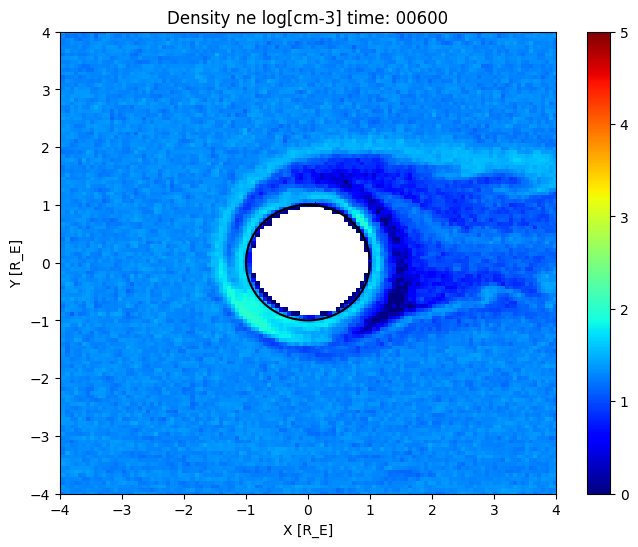

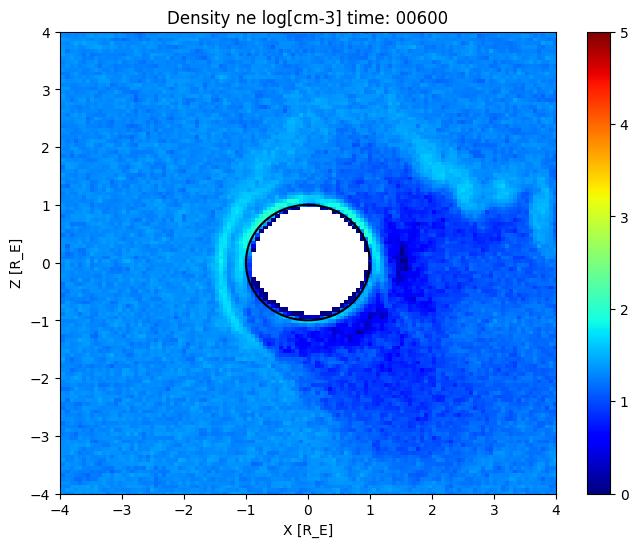

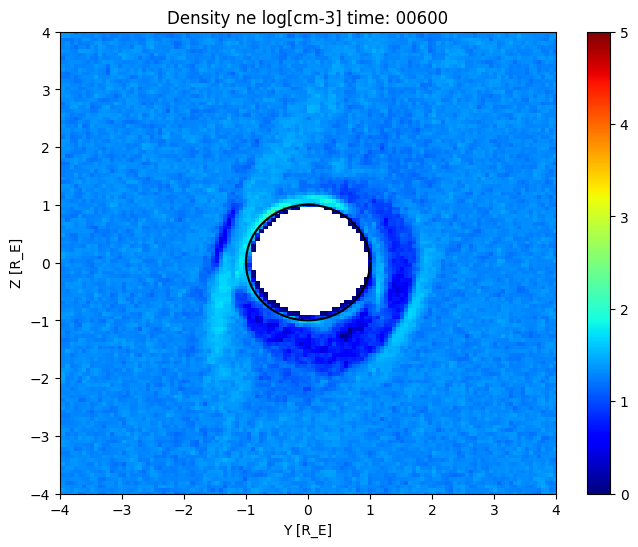

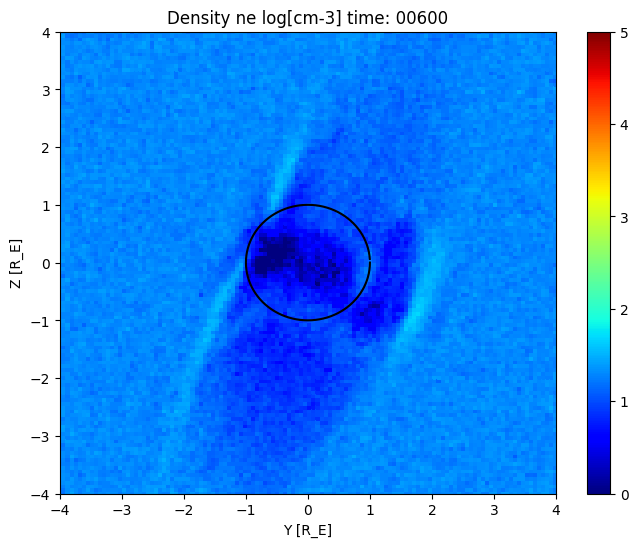

In [54]:
src_dir = "../Europa/"
typefile = "Ojv_"
rundate = "22_03_23"
diagtime = "00600"
plot_density_ne(src_dir,typefile,rundate,diagtime,zoom=True)